# Options 2: The Binomial Option Pricing Model

This notebook implements the binomial option pricing model for European and American style options. The appraoch is to set up, fill and store all important arrays (price of underlying asset, exercise decision, option value...in all periods and states) so we can analyze them. Code aimed at performance (rather than teaching) might avoid that.

You may also consider the [FinancialDerivatives.jl](https://github.com/JuliaQuant/FinancialDerivatives.jl) package for a more ambitious pricing models (not used here).

## Load Packages and Extra Functions

The [OffsetArrays.jl](https://github.com/JuliaArrays/OffsetArrays.jl) package allows flexible indexing of an array. In particular, it allows us to refer to the first element of a vector as element 0. This is useful in order to stick close to lecture notes on binomial trees where period $0$ is the starting point and we take $n$ time steps.

In [1]:
using Printf, OffsetArrays

include("src/printmat.jl");

In [2]:
using Plots
default(size = (480,320),fmt = :png)

# The Binomial Model for *One* Time Step

In a binomial model the price of the underlying asset can change from $S$ today to either $Su$ or $Sd$ in the next period (which is $h$ years from now).

Let $f_u$ and $f_d$ be the values of the derivative in the up- and down states (next period). Then, the value of the derivative today ($f$) is

$
f = e^{-yh}\left[  pf_{u}+\left(  1-p\right)  f_{d}\right] \: \text{ where } \: p=\frac{e^{yh}-d}{u-d}
$

Notice that $p$ denotes the "risk-neutral probability" of an up move. (Don't mix it with notation for a put price.)

As an example, for a call option that expires next period, the payoffs in the two states are

$
f_u = \max(Su-K,0)
$

$
f_d = \max(Sd-K,0)
$

For these equations to make sense, we need $u>e^{yh}>d$, which needs to be checked in any numerical implementation.

In [3]:
(S,K,y) = (10,10,0)             #underlying price today, strike pricem interest rate
(u,d,h) = (1.1,0.95,1/12)       #up move, down move, length of time period

fu = max(S*u-K,0)               #value of call option in up node
fd = max(S*d-K,0)               #in down node

p = (exp(y*h)-d)/(u-d)         #risk-neutral probability of "up" move
CallPrice = exp(-y*h)*(p*fu+(1-p)*fd)  #call option price today

printblue("Pricing of a call option with strike $K, one time step:\n")
printmat([fu,fd,p,CallPrice];rowNames=["Payoff 'up'","Payoff 'down'","p","Call price now"])

Pricing of a call option with strike 10, one time step:

Payoff 'up'        1.000
Payoff 'down'      0.000
p                  0.333
Call price now     0.333



# A CRR Tree for *Many* (Short) Time Steps

We now build a tree with $n$ steps of (time), each of length $h$, to reach expiration $m$ (so $nh=m$).

The CRR approach to construct $(u,d)$ is 

$
u=e^{\sigma\sqrt{h}} \: \text{ and }\: d=e^{-\sigma\sqrt{h}},
$

where $\sigma$ is the annualized standard deviation of the return on the underlying asset. Notice that $p$ depends on the choice of $(u,d)$ and also on $e^{yh}$

$
p=\frac{e^{yh}-d}{u-d}.
$

With these choices, $u>e^{yh}>d$ holds if $h$ is sufficiently small.

In [4]:
m = 0.5                 #time to expiration (in years)
y = 0.05                #interest rate (annualized)
σ = 0.2                 #annualized std of underlying asset

n = 50                  #number of time steps
h = m/n                 #time step size (in years)

u = exp(σ*sqrt(h))      #CRR approach
d = exp(-σ*sqrt(h))
p = (exp(y*h) - d)/(u-d)  #p depends on u and d

printblue("CRR parameters in tree when m=$m, y=$y, σ=$σ and n=$n:\n")
xx = [h,u,d,p,exp(y*h)]
printmat(xx;rowNames=["h","u","d","p","exp(yh)"])

printblue("Checking if u > exp(y*h) > d: ", u > exp(y*h) > d)

CRR parameters in tree when m=0.5, y=0.05, σ=0.2 and n=50:

h           0.010
u           1.020
d           0.980
p           0.508
exp(yh)     1.001

Checking if u > exp(y*h) > d: true


# Build a Tree for the Underlying Asset

The next few cells explain how we build a tree with $n$ time steps for the underlying asset.

## Creating a Vector of Vectors
of different lengths.

### A Remark on the Code

The next cell illustrates how we can create a vector of vectors (of different lengths). We use the OffsetArrays.jl package to set up the outer vector so that the first element has index 0. All the inner vectors are traditional, that is, the first index is 1.

In this example, `x[0]` is a vector `[0]`, while `x[1]` is a vector `[0,0]`, etc.

Using a vector of vector is more straightforward than filling half a matrix, and wastes less memory space.

In [5]:
x = [zeros(i+1) for i = 0:2]       #a vector or vectors (of different lengths)
x = OffsetArray(x,0:2)             #convert so the indices of x are 0:2

printblue("Illustrating a vector of vectors (of different lengths):\n")
for i in 0:2
    printblue("x[$i]:")
    printmat(x[i])
end

Illustrating a vector of vectors (of different lengths):

x[0]:
     0.000

x[1]:
     0.000
     0.000

x[2]:
     0.000
     0.000
     0.000



## Steps (Up and Down)

We create a tree by starting at the current spot price $S$. The subsequent nodes are then created by multiplying by $u$ or $d$. That is, the tree (vector of vectors) is built from the first ($0$) time step to the last ($n$) time step.

$\text{step 0}: (S)$ as `STree[0]`

$\text{step 1}: (Su,Sd)$  as `STree[1]`

$\text{step 2}: (Suu,Sud,Sdd)$ (since $Sud=Sdu$)  as `STree[2]`

...


### A Remark on the Code

Each time step is a vector and the vector of those vectors is the entire tree. For instance, for step 2, the code in the next cell creates the vector $(Suu,Sud,Sdd)$ by first multiplying the step 1 vector by the up factor (to get $u(Su,Sd)$) and then attaching (as the last element) the last element of the step 1 vector times the down factor (to get $dSd$).

In [6]:
"""
    BuildSTree(S,n,u,d)

Build binomial tree, starting at `S` and having `n` steps with up move `u` and down move `d`

# Output
- `STree:: Vector of vectors`: each (sub-)vector is for a time step. `STree[0] = [S]` and `STree[n]` is for time period n.

"""
function BuildSTree(S,n,u,d)
    STree = [fill(NaN,i) for i = 1:n+1]  #vector of vectors (of different lengths)
    STree = OffsetArray(STree,0:n)       #convert so the indices are 0:n
    STree[0][1] = S                      #step 0 is in STree[0], element 1
    for i in 1:n                          #move forward in time
        STree[i][1:end-1] = u*STree[i-1]       #most elements: up move from STree[i-1][1:end]
        STree[i][end]     = d*STree[i-1][end]  #last element: down move from STree[i-1][end]
    end
    return STree
end

BuildSTree

In [7]:
S     = 42.0
STree = BuildSTree(S,n,u,d);

## Showing the Tree for the Underlying Asset

The next few cells illustrate the tree. Notice that `STree[i][1]` is the highest value of the underlying for time step `i`, and that `STree[i][2]` is the second highest, etc.

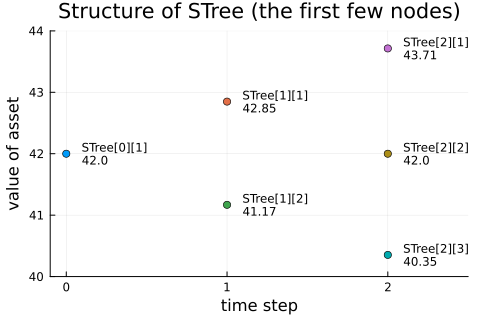

In [8]:
p1 = plot( legend = false,
           xlim = (-0.1,2.5),
           ylim = (40,44),
           xticks = 0:2,
           title = "Structure of STree (the first few nodes)",
           xlabel = "time step",
           ylabel = "value of asset" )
for i in 0:2, j in 1:length(STree[i])
    local txt1,txt2,txt
    txt1 = "STree[$i][$j]"
    txt2 = string(round(STree[i][j],digits=2))
    txt  = text(string(txt1,"\n",txt2),8,:left)    #adding this info to plot
    scatter!( [i],[STree[i][j]],annotation = (i+0.1,STree[i][j],txt) )
end
display(p1)           #needed since plot() does not have data points to plot

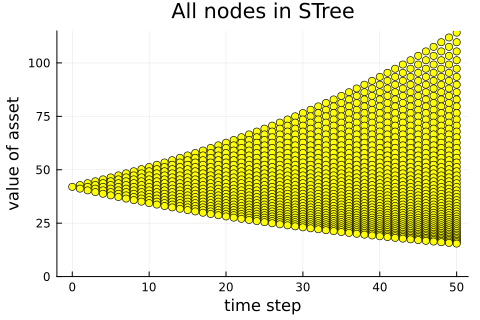

In [9]:
p1 = scatter( [0.0],STree[0],
              markercolor = :yellow,
              xlim = (-2,n+1.5),
              ylim = (0,115),
              legend = false,
              title = "All nodes in STree",
              xlabel = "time step",
              ylabel = "value of asset" )

for i in 1:n
    scatter!(fill(i,i+1),STree[i],color=:yellow)
end
display(p1)

# Calculating the Option Price

Let $f_{ij}$ be the option price at time step $i$ when the underlying price is $S_{ij}$. (We use $S_{ij}$ as a shorthand notation, to avoid writing things like $Sudd$.) 

For a European call option, the call price at the *last time step* $n$ is 
$f_{nj} = \max(0,S_{nj}-K)$ for each node $j$. Similarly, the put price is $f_{nj} = \max(0,K-S_{nj})$.

For all *earlier time steps*, the value is 

$
f_{ij} = e^{-yh}[p f_{i+1,j} + (1-p) f_{i+1,j+1}].
$

In the code below, $f_{i+1,1}$ refers to the highest node (of the underlying) in time step $i+1$, $S_{i+1,2}$ tp the second highest in the same time step, etc. Notice that we calculate the option price from the last time step ($n$) to the first ($0$).

### A Remark on the Code
- Inside the function `EuOptionPrice()`, `Value = similar(STree)` is used to create a new vector (of vectors) called `Value` with the same structure as `STree`.
- The `;isPut=false` creates a keyword argument which defaults to `false`. To calculate a put price, call the function as `EuOptionPrice(STree,K,y,h,p;isPut=true)`.
- The code `Value[n] = isPut ? max.(0,K.-STree[n]) : max.(0,STree[n].-K)` is a short form of an `if...else...end` and does the same as
```
if isPut
    Value[n] = max.(0,K.-STree[n])
else
    Value[n] = max.(0,STree[n].-K)
end
```
- `only(Pₑ[0])` creates a scalar from an array with one element. (Similar to `Pₑ[0][1]` but with error checking.)

## European Options

In [10]:
"""
    EuOptionPrice(STree,K,y,h,p;isPut=false)

Calculate price of European option from binomial model

# Output
- `Value:: Vector of vectors`: option values at different nodes, same structure as STree

"""
function EuOptionPrice(STree,K,y,h,p;isPut=false)
    Value    = similar(STree)                            #tree for derivative, to fill
    n        = length(STree) - 1                         #number of steps in STree
    Value[n] = isPut ? max.(0,K.-STree[n]) : max.(0,STree[n].-K)  #last time node
    for i in n-1:-1:0                                   #move backward in time
        Value[i] = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
    end                                           #p*up + (1-p)*down, discount
    return Value
end

EuOptionPrice

In [11]:
K = 42.0                                  #strike price

Pₑ = EuOptionPrice(STree,K,y,h,p;isPut=true)        #Pₑ[0] is a 1-element vector with the put price (node 0)
Cₑ = EuOptionPrice(STree,K,y,h,p)

Cₑ_parity = only(Pₑ[0]) + S - exp(-m*y)*K           #put-call parity, only(Pₑ[0]) makes it a scalar

printblue("European option prices at K=$K and S=$S: ")
printmat([only(Pₑ[0]),only(Cₑ[0]),Cₑ_parity];rowNames=["put","call","call from parity"])

European option prices at K=42.0 and S=42.0: 
put                  1.844
call                 2.881
call from parity     2.881



## Routines for the Same Calculations, but Using Matrices to Store the Results (extra)

If you want to port the code to another language where a vector of vectors is tricky, then you might consider starting with the functions included below.

In [12]:
include("src/OptionsBopmMatrix.jl")
STreeM = BuildSTreeM(S,n,u,d)

println("first upper 4x4 block of the matrix:")
printmat(STreeM[1:4,1:4])

Pₑ₂ = EuOptionPriceM(STreeM,K,y,h,p;isPut=true)
printlnPs("put price: ",Pₑ₂[1,1])

first upper 4x4 block of the matrix:
    42.000    42.848    43.714    44.597
       NaN    41.168    42.000    42.848
       NaN       NaN    40.353    41.168
       NaN       NaN       NaN    39.554

put price:      1.844


## American Options

The option values are calculated as for the European option, except that that the option value is 

$f_{ij} = \max(\text{value if exercised now},\text{continuation value})$

The *continuation value* has the same form as in the European case, and thus assumes that the option has not been exercised before the next period.

The *value of exercising now* is $S_{ij}-K$ for a call and $K-S_{ij}$ for a put.

In [13]:
"""
    AmOptionPrice(STree,K,y,h,p;isPut=false)

Calculate price of American option from binomial model

# Output
- `Value:: Vector of vectors`: option values at different nodes, same structure as STree
- `Exerc:: Vector of vectors`: true if early exercise at the node, same structure as STree

"""
function AmOptionPrice(STree,K,y,h,p;isPut=false)     #price of American option
    Value = similar(STree)                            #tree for derivative, to fill
    n     = length(STree) - 1
    Exerc = similar(Value,BitArray)               #same structure as STree, but BitArray, empty
    Value[n] = isPut ? max.(0,K.-STree[n]) : max.(0,STree[n].-K)  #last time node
    Exerc[n] = Value[n] .> 0                      #exercise
    for i in n-1:-1:0                                    #move backward in time
        fa  = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
        Value[i] = isPut ? max.(K.-STree[i],fa) : max.(STree[i].-K,fa)    #put or call
        Exerc[i] = Value[i] .> fa                   #true if early exercise
    end
    return Value, Exerc
end

AmOptionPrice

In [14]:
K = 42.0                                  #strike price

(Pₐ,Exerc)  = AmOptionPrice(STree,K,y,h,p;isPut=true)
(Cₐ,ExercC) = AmOptionPrice(STree,K,y,h,p)

printblue("Put and call prices at K=$K and S=$S: ")
xx = [ only(Pₐ[0]) only(Pₑ[0]);only(Cₐ[0]) only(Cₑ[0]) ]
printmat(xx;colNames=["American","European"],rowNames=["put","call"])

printred("When is the American option worth more? When the same?")

Put and call prices at K=42.0 and S=42.0: 
      American  European
put      1.950     1.844
call     2.881     2.881

When is the American option worth more? When the same?


## Plotting the Tree of American Option Values

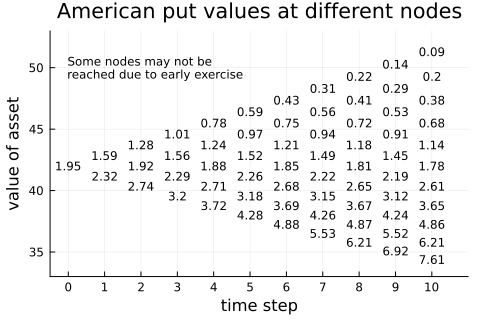

In [15]:
p1 = plot( xlim = (-0.5,11),
           ylim = (33,53),
           xticks = 0:10,
           legend = false,
           title = "American put values at different nodes",
           xlabel = "time step",
           ylabel = "value of asset",
           annotation = (0,50,text("Some nodes may not be\nreached due to early exercise",8,:left)) )
for i in 0:10, j in 1:length(STree[i])
    annotate!(i,STree[i][j],text(string(round(Pₐ[i][j],digits=2)),8))
end
display(p1)

## Plotting where Exercise Happens

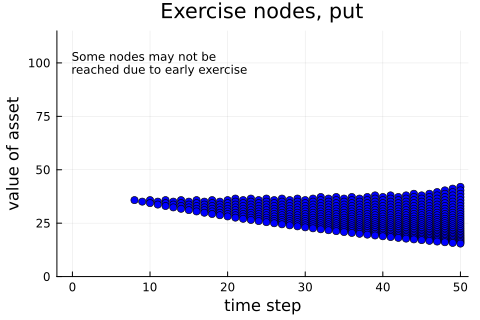

In [16]:
p1 = plot( xlim = (-2,n+1),
           ylim = (0,115),
           legend = false,
           title = "Exercise nodes, put",
           xlabel = "time step",
           ylabel = "value of asset",
           annotation = (0,100,text("Some nodes may not be\nreached due to early exercise",8,:left)) )
for i in 0:n, j in 1:length(STree[i])
    if Exerc[i][j]
        scatter!([i],[STree[i][j]],markercolor=:blue)
    end
end
display(p1)

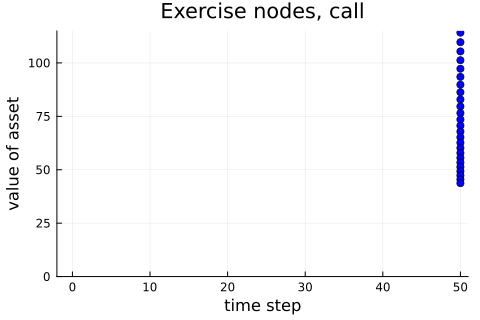

In [17]:
p1 = plot( xlim = (-2,n+1),
           ylim = (0,115),
           legend = false,
           title = "Exercise nodes, call",
           xlabel = "time step",
           ylabel = "value of asset")
for i in 0:n, j in 1:length(STree[i])
    if ExercC[i][j]
        scatter!([i],[STree[i][j]],markercolor=:blue)
    end
end
display(p1)